<a href="https://colab.research.google.com/github/uptrain-ai/uptrain/blob/main/examples/integrations/vector_db/qdrant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="UpTrain">
  </a>
</h1>

<div style="text-align: center;">

# Retrieving Context Documents using QDrant & Evaluating the Quality of Retrieved Context using UpTrain

</div>


## What is a Vector Database?

Vector databases store data as high-dimensional vectors, enabling fast and efficient similarity search and retrieval of data based on their vector representations.

This is particularly useful for large language models (LLMs), which need to process vast amounts of data and find relevant information quickly.

## What role does Qdrant play in your RAG based application?

[Qdrant](https://github.com/qdrant/qdrant) (pronounced: quadrant) is a vector similarity search engine and vector database. While working on RAG based applications, you can use QDrant to retrieve information from your context documents.

## Why do I need to monitor the retrieval quality?

Let's say a user asks your LLM application a question on refunds, maybe something like: "How can I initiate a refund on my last purchase?". Ideally, the retrieved context should contain two important pieces of information: "the user's last purchase" and "the company's policy on refunds". Now, what if the retrieved context doesn't contain that information or the fetched information is irrelevant. That's where UpTrain comes in, by helping you evaluate the relevance of the retrieved context.

## Overview of this notebooks

In this notebook, we will walk you through some basic applications in RAG, using QDrant as a vector DB for your context documents. Subsequently, we will use UpTrain to evaluate the quality (relevance) of these retrieved contexts. For simplicity, we have divided this notebook into the following 3 parts:

1. **Data Preparation and Embedding:**
   We will begin by processing and embedding our data using a suitable sentence transformer model. This creates high-dimensional vector representations capturing the semantic meaning of each data point.

2. **Vector Search with Qdrant:**
   We will then leverage Qdrant's efficient vector search capabilities to retrieve relevant results based on a query vector, allowing us to explore the semantic relationships within the data.

3. **UpTrain Evaluation of Retrieved Content:**
   Utilizing UpTrain's pre-built and custom evaluation checks, we will analyze the quality of the retrieved search results. This assessment focuses on aspects such as context relevance, factual accuracy, and response completeness wrt context, providing valuable insights into the effectiveness of the search process.


If you face any difficulties, need some help with using UpTrain or want to brainstorm custom evaluations for your use-case, you can speak to the maintainers of UpTrain [here](https://calendly.com/uptrain-sourabh/30min).


## Step 1 : Install libraries and make necessary imports


In [2]:
!pip install -qU qdrant-client uptrain sentence-transformers

In [3]:
import json

from qdrant_client import models, QdrantClient
from sentence_transformers import SentenceTransformer
from uptrain import EvalLLM, Evals, APIClient, Settings

## Step 2: Define your document to be embedded

Let's make a semantic search for Sci-Fi books!


In [6]:
texts = [
    {
        "name": "A Gift From The Stars",
        "description": "This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.",
        "author": "Elena Dannan",
        "year": 2020,
    },
    {
        "name": "The Time Machine",
        "description": "A man travels through time and witnesses the evolution of humanity.",
        "author": "H.G. Wells",
        "year": 1895,
    },
    {
        "name": "Ender's Game",
        "description": "A young boy is trained to become a military leader in a war against an alien race.",
        "author": "Orson Scott Card",
        "year": 1985,
    },
    {
        "name": "The Royal Abduction",
        "description": "Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past.",
        "author": "Vikram Singh",
        "year": 2023,
    },
]

[{'name': 'A Gift From The Stars',
  'description': 'This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.',
  'author': 'Elena Dannan',
  'year': 2020},
 {'name': 'The Time Machine',
  'description': 'A man travels through time and witnesses the evolution of humanity.',
  'author': 'H.G. Wells',
  'year': 1895},
 {'name': "Ender's Game",
  'description': 'A young boy is trained to become a military leader in a war against an alien race.',
  'author': 'Orson Scott Card',
  'year': 1985},
 {'name': 'The Royal Abduction',
  'description': 'Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past.',
  'author': 'Vikram Singh',
  'year': 2023}]

## Step 3: Choose your embedding model and create a memory instance for the same


In [7]:
# Create sentence transformer model for generating embeddings
encoder = SentenceTransformer("all-MiniLM-L6-v2")

# Create in-memory Qdrant instance
qdrant = QdrantClient(":memory:")

# Create collection to store books
qdrant.recreate_collection(  
    collection_name="my_books",
    vectors_config=models.VectorParams(
        # Vector size is defined by used model
        size=encoder.get_sentence_embedding_dimension(),
        distance=models.Distance.COSINE,
    ),
)

config_sentence_transformers.json: 100%|██████████| 116/116 [00:00<00:00, 431kB/s]
README.md: 100%|██████████| 10.6k/10.6k [00:00<00:00, 13.9MB/s]
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<00:00, 140kB/s]
config.json: 100%|██████████| 612/612 [00:00<00:00, 1.82MB/s]
pytorch_model.bin: 100%|██████████| 90.9M/90.9M [00:47<00:00, 1.91MB/s]
/Users/dhruvchawla/Work/uptrain-v1/.venv/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
tokenizer_config.json: 100%|██████████| 350/350 [00:00<00:00, 1.03MB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 549kB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 2.12MB/s]
1_Pooling/config.jso

True

## Step 4: Generate embedding and vectorise from the defined text in the previous step


In [9]:
# Generate embeddings for the texts
embeddings = encoder.encode(texts)

# Upload embeddings to the specified collection
qdrant.upload_points(
    collection_name="my_books",
    points=[
        models.Record(id=idx, vector=embedding.tolist())
        for idx, embedding in enumerate(embeddings)
    ],
)

# Vectorize descriptions and upload to qdrant
qdrant.upload_points(
    collection_name="my_books",
    points=[
        models.Record(
            id=idx, vector=encoder.encode(doc["description"]).tolist(), payload=doc
        )
        for idx, doc in enumerate(texts)
    ],
)

## Step 5: Define question and fetch relevant information from Qdrant


In [10]:
question = "What are some books that talk about alien abductions?"

hits = qdrant.search(
    collection_name="my_books", query_vector=encoder.encode(question).tolist()
)
hits

[ScoredPoint(id=0, version=0, score=0.5909586701910323, payload={'name': 'A Gift From The Stars', 'description': 'This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.', 'author': 'Elena Dannan', 'year': 2020}, vector=None, shard_key=None),
 ScoredPoint(id=3, version=0, score=0.2930183643295886, payload={'name': 'The Royal Abduction', 'description': 'Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past.', 'author': 'Vikram Singh', 'year': 2023}, vector=None, shard_key=None),
 ScoredPoint(id=1, version=0, score=0.15001676944157682, payload={'name': 'The Time Machine', 'description': 'A man travels through time and witnesses the evolution of humanity.', 'author': 'H.G. Wells

Let's have a look at one of the retrieved context documents:

In [11]:
hits[0].payload

{'name': 'A Gift From The Stars',
 'description': 'This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.',
 'author': 'Elena Dannan',
 'year': 2020}

Store the results in required format


In [12]:
data = []
for hit in hits:
    data.append(
        {
            "question": question,
            "context": "Book Description for "
            + hit.payload.get("name", "")
            + " : "
            + hit.payload.get("description", ""),
        }
    )
data

[{'question': 'What are some books that talk about alien abductions?',
  'context': 'Book Description for A Gift From The Stars : This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.'},
 {'question': 'What are some books that talk about alien abductions?',
  'context': 'Book Description for The Royal Abduction : Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past.'},
 {'question': 'What are some books that talk about alien abductions?',
  'context': 'Book Description for The Time Machine : A man travels through time and witnesses the evolution of humanity.'},
 {'question': 'What are some books that talk about alien abductions?',
  'context': "Book Description for Ender's

## Step 6: Evaluating the retrieved context's quality using UpTrain's Open-Source Software (OSS)


In [17]:
OPENAI_API_KEY = "sk-###############"  # Insert your OpenAI key here

eval_llm = EvalLLM(
    Settings(openai_api_key=OPENAI_API_KEY, response_format={"type": "json_object"})
)

res = eval_llm.evaluate(data=data, checks=[Evals.CONTEXT_RELEVANCE])

print(json.dumps(res, indent=3))

2024-01-30 19:15:22.787 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain


[
   {
      "question": "What are some books that talk about alien abductions?",
      "context": "Book Description for A Gift From The Stars : This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.",
      "score_context_relevance": 1.0,
      "explanation_context_relevance": "The extracted context provides a specific book description that directly addresses the question about books on alien abductions. Hence, the selected choice is (A)"
   },
   {
      "question": "What are some books that talk about alien abductions?",
      "context": "Book Description for The Royal Abduction : Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past.",
      "score_context_relevance": 0.

## [Optional] Step 7: UpTrain Managed Service and Dashboards


You can create a free UpTrain account [here](https://uptrain.ai/) and get free trial credits. If you want more trial credits, [book a call with the maintainers of UpTrain here](https://calendly.com/uptrain-sourabh/30min).


UpTrain Managed service provides:

1. Dashboards with advanced drill-down and filtering options
2. Insights and common topics among failing cases
3. Observability and real-time monitoring of production data
4. Regression testing via seamless integration with your CI/CD pipelines


In [15]:
UPTRAIN_API_KEY = "up-######################"  # Insert your UpTrain API key here

uptrain_client = APIClient(
    Settings(
        uptrain_access_token=UPTRAIN_API_KEY, response_format={"type": "json_object"}
    )
)

res = uptrain_client.log_and_evaluate(
    "Qdrant-context-sample-evals", data, [Evals.CONTEXT_RELEVANCE]
)

print(json.dumps(res, indent=3))

2024-01-30 18:57:08.889 | INFO     | uptrain.framework.remote:log_and_evaluate:507 - Sending evaluation request for rows 0 to <50 to the Uptrain server


[
   {
      "question": "What are some books that talk about alien abductions?",
      "context": "Book Description for A Gift From The Stars : This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.",
      "score_context_relevance": 1.0,
      "explanation_context_relevance": "The extracted context provides a specific book description that directly addresses the question about books on alien abductions. Hence, the selected choice is (A)"
   },
   {
      "question": "What are some books that talk about alien abductions?",
      "context": "Book Description for The Royal Abduction : Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past.",
      "score_context_relevance": 0.

### Dashboards:

Histogram of score vs number of cases with that score

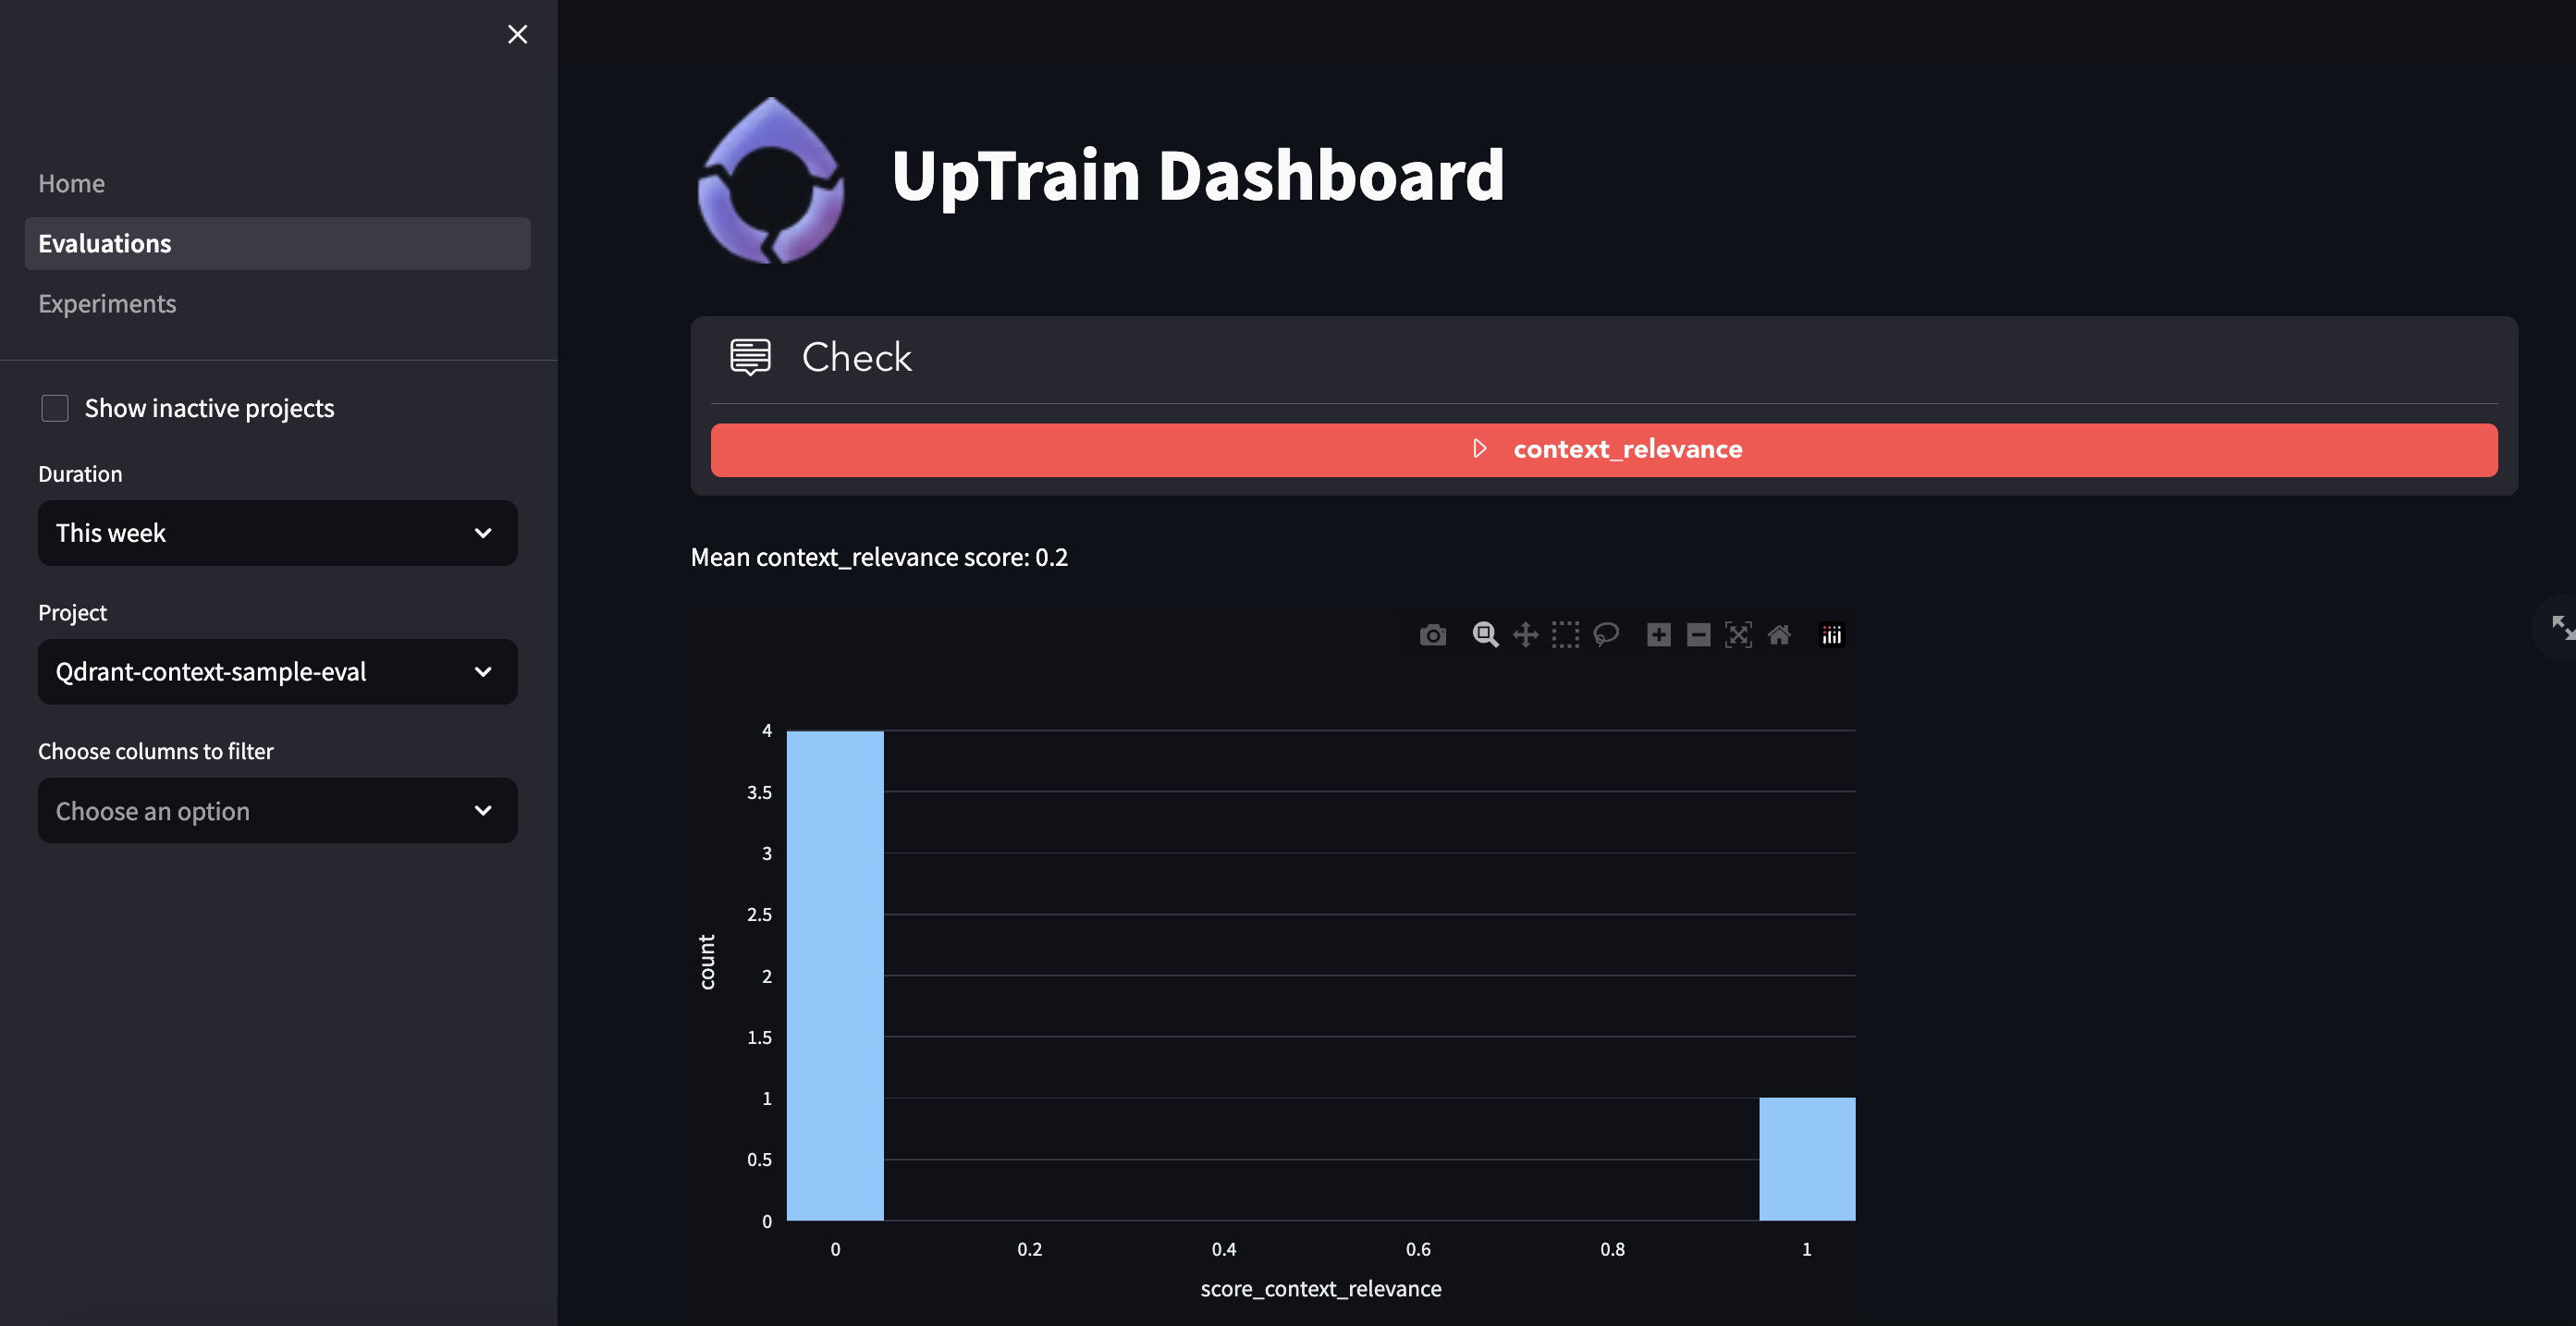


You can access the uptrain dashboards [here](https://demo.uptrain.ai/dashboard/) by using the above defined UPTRAIN_API_KEY


### Insights:

You can filter failure cases and generate common topics among them. This can help identify the core issue and help fix it

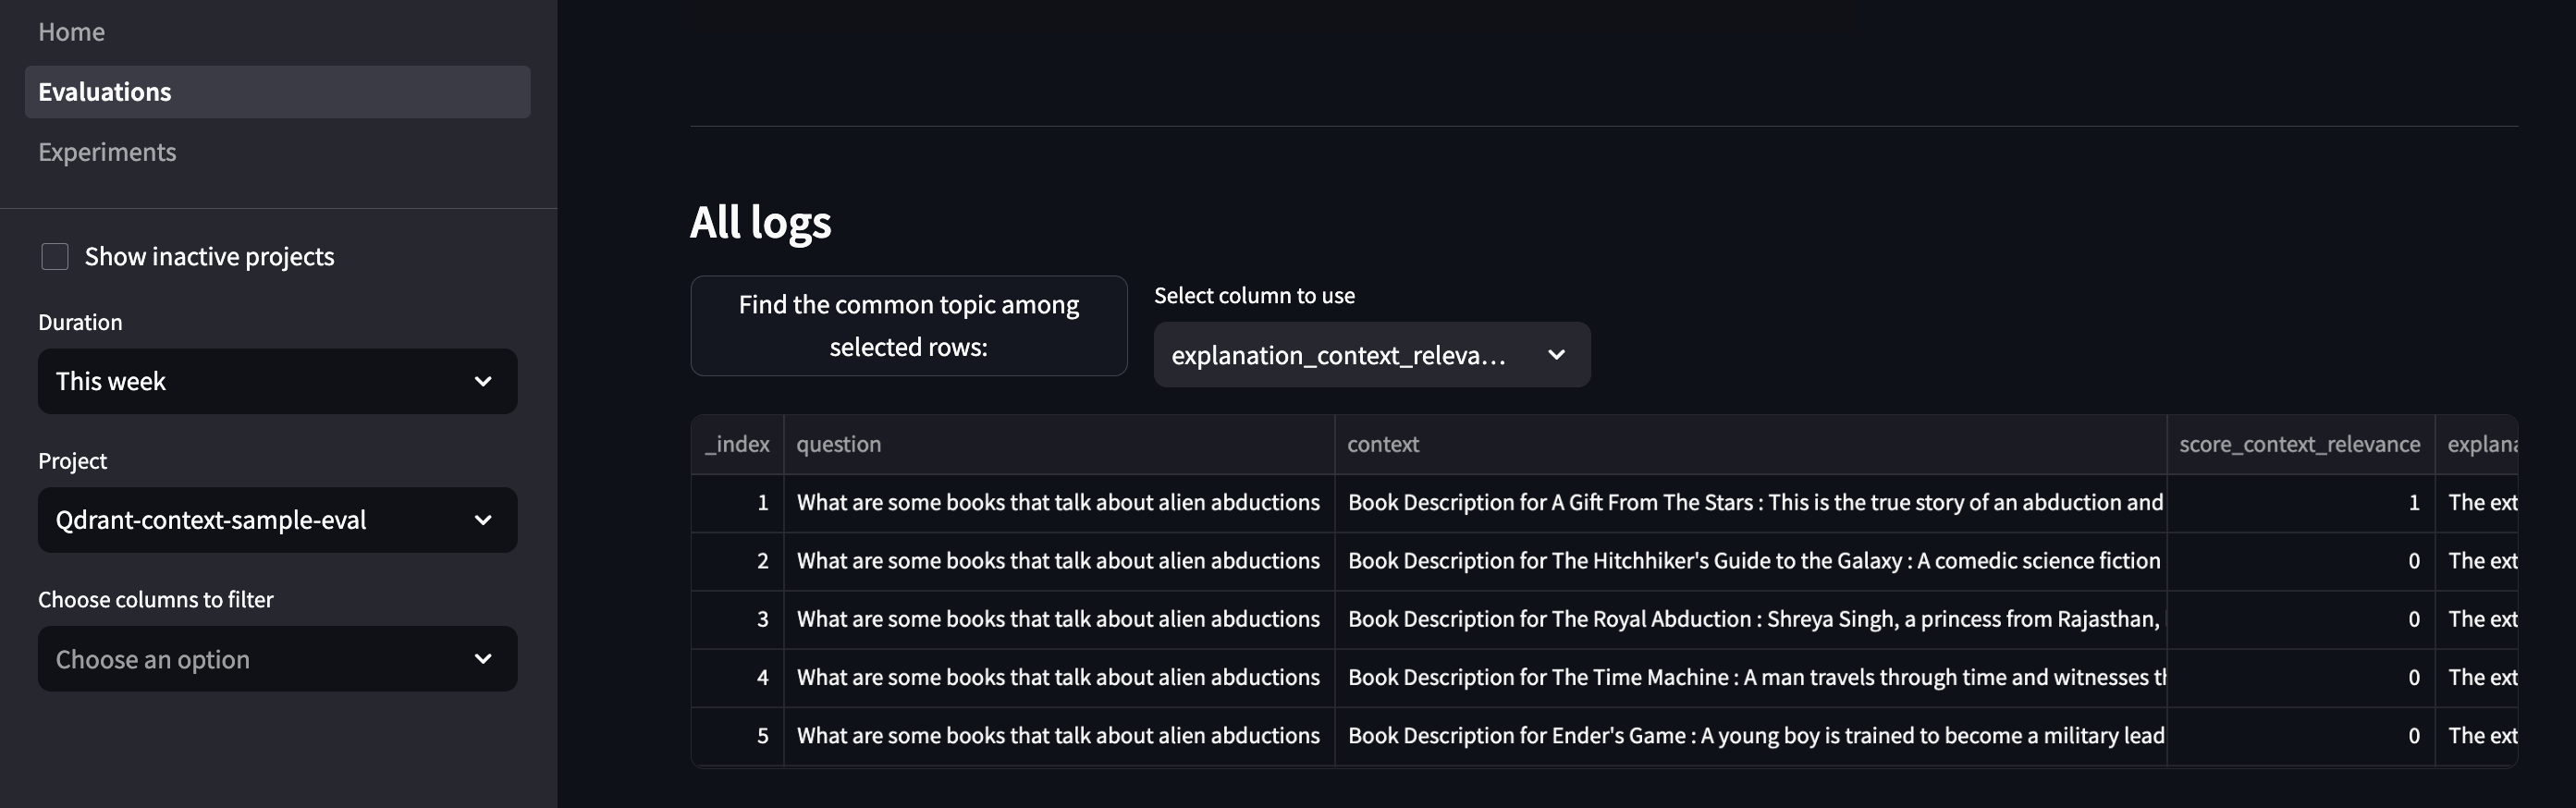
